
# Prediction with a pre-trained model 

**Note.** The pretreained model given in the github repository (proposed in the paper)  has `Total params: 9,422,977`. The one we use with `unet.py` has `Total params: 1,459,585`.

If we read the output of `loaded_model.get_config()` from the pretreained model, we find that the original model used `512` filters in the conv_4 layers. The model we have in `unet.py` only uses 128 filters in these layers.

Running both models, I find similar results. The small model will be much faster to train.

In [1]:
import sys # to load custom python code
sys.path.append('...\\Source')

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import numpy as np

In [3]:
from tensorflow.keras.models import load_model # to load model

In [4]:
# Custom packages:
from unet import unet, Bigunet
from patchProcessAssemble import Normalize, Mask #, PatchProcessAssemble 
from visualize import vol

In [5]:
# set gaussian weights in the overlap boundaries
def getMask(os):
    sc = np.zeros((n1,n2,n3),dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)
    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n3-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

In [6]:
# This works for the Big pretrained model (and is much cleaner than using the .json file as the cell below):
# training image dimensions
n1, n2, n3 = 128, 128, 128
model = unet(input_size=(n1, n2, n3, 1))        # set architecture
#model = Bigunet(input_size=(n1, n2, n3, 1))        # set architecture

#model.load_weights("D:\\Tesis\mode\\pretrained_model.hdf5") # get weights from original model from git-hub
model.load_weights("...\\weights.h5")# get weights from localGPU


model.summary()                                   # check summary

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 6928        conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 64, 64, 64, 1 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

# FILTERS AND BIASES

In [7]:
# summarize filter shapes
for layer in model.layers:
 # check for convolutional layer
 if 'conv' not in layer.name:
    continue
 # get filter weights
 filters, biases = layer.get_weights()
 print(layer.name, filters.shape)

conv3d (3, 3, 3, 1, 16)
conv3d_1 (3, 3, 3, 16, 16)
conv3d_2 (3, 3, 3, 16, 32)
conv3d_3 (3, 3, 3, 32, 32)
conv3d_4 (3, 3, 3, 32, 64)
conv3d_5 (3, 3, 3, 64, 64)
conv3d_6 (3, 3, 3, 64, 128)
conv3d_7 (3, 3, 3, 128, 128)
conv3d_8 (3, 3, 3, 192, 64)
conv3d_9 (3, 3, 3, 64, 64)
conv3d_10 (3, 3, 3, 96, 32)
conv3d_11 (3, 3, 3, 32, 32)
conv3d_12 (3, 3, 3, 48, 16)
conv3d_13 (3, 3, 3, 16, 16)
conv3d_14 (1, 1, 1, 16, 1)


In [8]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(np.shape(filters))
print(np.shape(biases))

(3, 3, 3, 1, 16)
(16,)


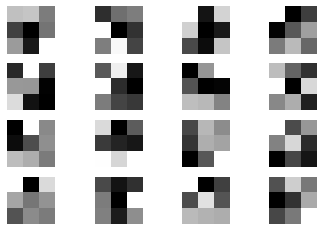

In [10]:
# plot each filter
for i in range(16):
    filter = filters[:, :, :, 0, i]
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.imshow(filter[:, :, 0], cmap='gray')
plt.show()

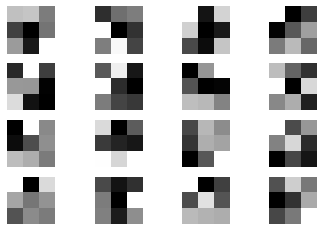

In [11]:
# plot each filter in 2D
for i in range(16):
    filter = filters[:, :, :, 0, i]
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.imshow(filter[:, :, 0], cmap='gray')
plt.show()

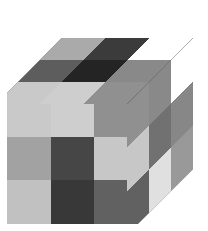

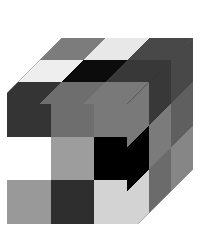

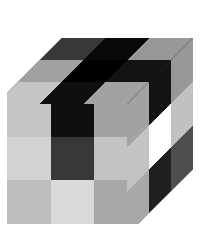

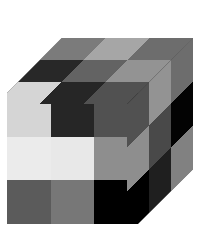

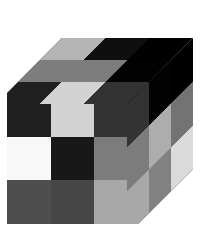

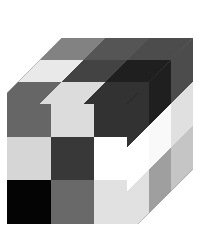

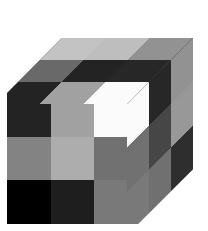

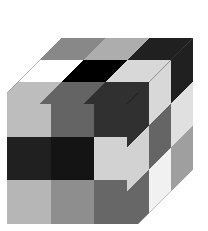

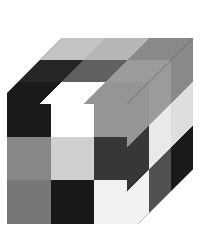

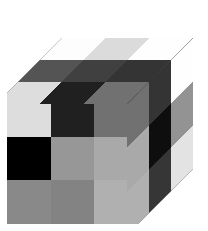

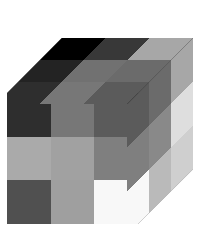

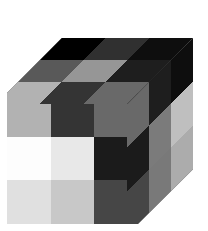

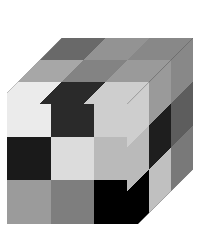

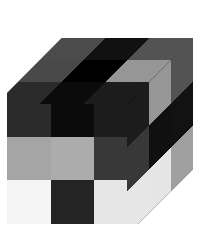

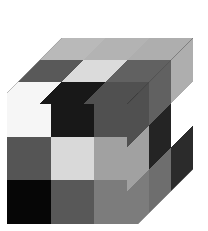

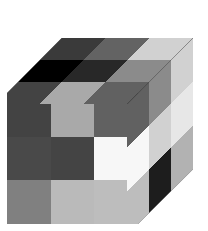

In [12]:
# plot each filter in 3D
for i in range(16):
    filter = filters[:, :, :, 0, i]
    vol(filter,cmap='gray')
    plt.axis('off')
plt.show()

### Check model IO (input$\to$ output)

Check that the models outputs something. Plot this for reference in the thesis.

1/1 [==============================] - 8s 8s/step


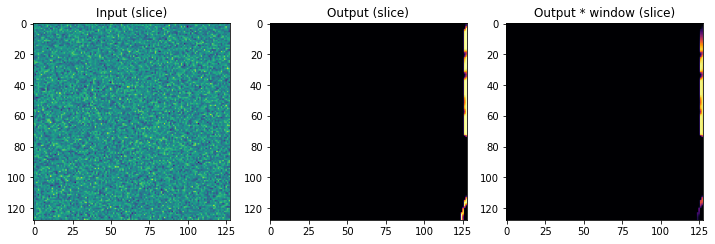

In [9]:
# dato:
gx  = np.random.normal(size=n1*n2*n3).reshape(n1,n2,n3)
# ventana
M   = 20
win = Mask(n1,n2,n3,M)
#win = getMask(M) # salta a la vista un error en la ventana del source original ! Unos bordes en la región de la ventana.
#gx  = win*gx # si tapo esto veo el efecto sobre los bordes al no utilizar ventana: OK
# normalizar
gx  = Normalize(gx) 


# convertir a tensor para el modelo:
x   = np.reshape(gx,(1,n1,n2,n3,1))


# predecir
Y   = model.predict(x,verbose=1)


# Remuevo dimensiones para graficar
x = x.squeeze() # (1,n1,n2,n3,1) => (n1,n2,n3)
Y = Y.squeeze() # (1,n1,n2,n3,1) => (n1,n2,n3)
Yw = Y*win

# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.title("Input (slice)")
plt.imshow(x[:,:,n3//2],cmap="viridis")
plt.subplot(1,3,2)
plt.title("Output (slice)")
plt.imshow(Y[:,:,n3//2],cmap="inferno")
plt.subplot(1,3,3)
plt.title("Output * window (slice)")
plt.imshow(Yw[:,:,n3//2],cmap="inferno")
plt.show()

<Figure size 432x288 with 0 Axes>

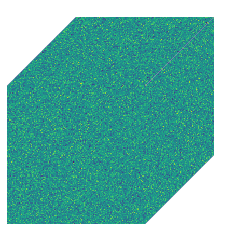

<Figure size 432x288 with 0 Axes>

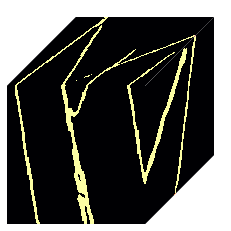

<Figure size 432x288 with 0 Axes>

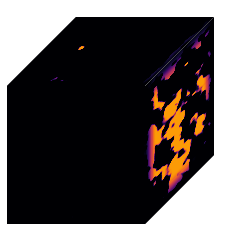

In [20]:
# 3D view
plt.figure()
vol(x,cmap="viridis")
plt.show()
plt.figure()
#vol(Y,cmap="inferno")
#plt.show()
#plt.figure()
vol(Yw,cmap="inferno")
plt.show()

**Note**. Can we correct the model so it does not predict faults on random data? How to do so? Perhaps in the training stage, we can pass random cubes with labels of full zeros (e.g., a random cube as `X`, and a cube of all zeros as `Y`).

### Ventanas: análisis 1D

Conviene que la ventana no lleve a `0` para que TF no se queje.

In [ ]:
# Hamming window with tensorflow.signal:
M = 5
N = 2*M+1
window = tf.signal.hamming_window(window_length=N, dtype=tf.dtypes.float32)
skirt  = window.numpy()[:M]
plt.figure(figsize=(3,2))
plt.plot(window.numpy(),color="gray");
plt.plot(skirt,color="red")
plt.show()

In [ ]:
os = 50
tt = Mask(n1,n2,n3,os)
sc = getMask(os)

In [ ]:
# Plot
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(sc[:,os,os],lw=5,color="black",label="Gaussian (paper)")
plt.plot(tt[:,os,os],lw=5,color="tomato",label="JLG y FC")
plt.legend()
plt.subplot(1,3,2)
#plt.plot(sc[os,:,os],lw=3)
plt.plot(sc[os,:,os],lw=5,color="black")
plt.plot(tt[os,:,os],lw=5,color="tomato")
plt.subplot(1,3,3)
plt.plot(sc[os,os,:],lw=5,color="black")
plt.plot(tt[os,os,:],lw=5,color="tomato")
plt.show()
print("Sample value at beginning of window:",sc[0,0,0],tt[0,0,0])

# Prediction test on a training image 


EN EL MODELO ENTRENADO POR MI, TUVE QUE CAMBIAR LA NORMALIZACIÓN (whittening) DEL DATO DE ENTRADA Y TRASPONER EL DATO.

**Nota**. ¿Qué representa `accuracy` en los resultados del paper original? Dado que la salida del modelo es un volumen con valores en (0,1), `accuracy` debería ser nula, ya que prácticamente nunca pegaria un pixel del dato predicho con el valor del volumen sintético de fallas (que vale 0 ó 1). Creo debería usarse como medida el RMSE o similar.

tf.Tensor([b'D:\\Tesis\\faultSeg-master\\data\\validation\\seis\\0.dat'], shape=(1,), dtype=string)
b'D:\\Tesis\\faultSeg-master\\data\\validation\\seis\\0.dat'


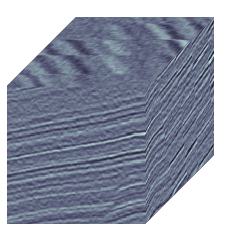

In [13]:
# Mirar esto para más adelante:
# Genera Dataset con la lista de archivos y elijo algunos para ver:
list_seis  = tf.data.Dataset.list_files(str("D:\\Tesis\\faultSeg-master\\data\\validation\\seis\\*.dat"),shuffle=True).batch(1)
for file in list_seis.take(1):  # only take one at random from the list
    print(file)
    print(file.numpy()[0]) # fist element of list
    seis_file  = file.numpy()[0]
    gx = np.fromfile(seis_file,dtype=np.single)    
    gx = np.reshape(gx,(128,128,128))   
    vol(gx,cmap="bone")
    plt.show()       

In [14]:
fx=np.fromfile("..\\data\\validation\\fault\\12.dat", dtype=np.single)
fx = np.reshape(fx,(128,128,128)) 

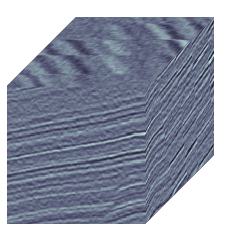

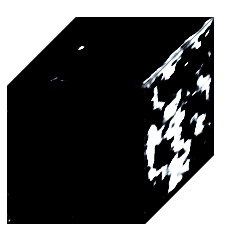

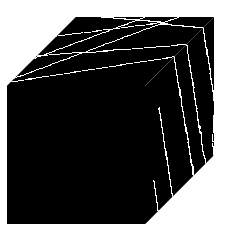

In [15]:
# 3D View
vol(gx,cmap="bone")
plt.show()
vol(Y,cmap="bone")
plt.show()
vol(fx,cmap="gray")
plt.show()

1/1 [==============================] - 0s 69ms/step
Root Mean Squared Error: 0.13455541
Root Mean Squared Error: 0.13455541
BinaryAccuracy: 0.9807563
Accuracy:  0.9807562828063965


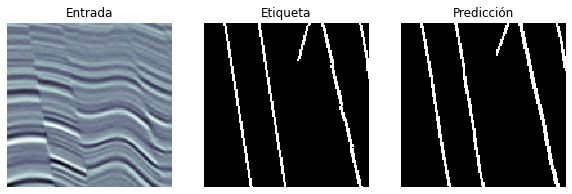

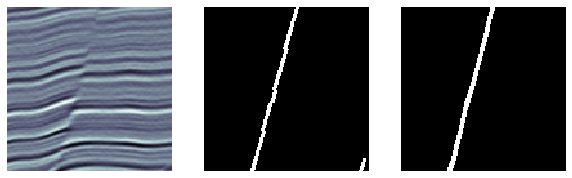

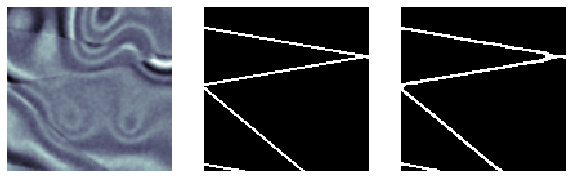

<Figure size 432x288 with 0 Axes>

In [16]:
n1,n2,n3 = 128,128,128
gx = np.fromfile("...\\data\\validation\\seis\\10.dat",dtype=np.single)#.squeeze()
fx = np.fromfile("...\\data\\validation\\fault\\10.dat",dtype=np.single)#.squeeze()
fx = tf.reshape(fx,(1,n1,n2,n3,1))

# WATCH OUT FOR NORMALIZATION AND TRANPOSITION:
gx  = Normalize(gx) # check what happens if we do not normalize the input volume ...
gx  = np.reshape(gx,(n1,n2,n3))
gx  = tf.image.per_image_standardization(gx) # otra forma de normalizar (equivalente a Normalize() )
gx  = tf.transpose(gx)
gx  = tf.reshape(gx,(1,n1,n2,n3,1))
Y   = model.predict(gx,verbose=1)
Y   = tf.transpose(Y)
gx  = tf.transpose(gx)

# Root Mean Squared Error:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(Y, fx)
print("Root Mean Squared Error:", m.result().numpy())
print("Root Mean Squared Error:", tf.sqrt(tf.reduce_mean(tf.pow(tf.subtract(Y,fx),2))).numpy())
# Accuracy
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(fx, Y)
print("BinaryAccuracy:",m.result().numpy())




# Plot

gx = tf.squeeze(gx).numpy()
Y  = tf.squeeze(Y).numpy()
fx = tf.squeeze(fx).numpy()


threshold = 0.5 # PLAY WITH THIS
Y[ Y <= threshold ] = 0.  
Y[ Y > threshold  ] = 1.
acc = np.average(fx == Y)  
print("Accuracy: ",acc)



k1,k2,k3 = 50,110,60
plt.figure(figsize=(10,10))
#inline slice
plt.subplot(1, 3, 1)
plt.title("Entrada")
plt.imshow(np.transpose(gx[k1,:,:]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Etiqueta")
plt.imshow(np.transpose(fx[k1,:,:]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title("Predicción")
plt.imshow(np.transpose(Y[k1,:,:]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.axis("off")
# xline slice
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(np.transpose(gx[:,k2,:]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(np.transpose(fx[:,k2,:]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(np.transpose(Y[:,k2,:]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.axis("off")
plt.show()
# time-slice
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(np.transpose(gx[...,k3]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(np.transpose(fx[...,k3]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(np.transpose(Y[...,k3]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.axis("off")
plt.show()

plt.savefig("D:\\Tesis\\Bibliografia\\Tesis_Imagenes\\testeo10.jpg", bbox_inches='tight')

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
#Ahora voy a calcular algunas metricas para un cubo en particular, podria extenderse a todo el set de datos agregando otro bucle?

matrix0=np.zeros((2,2))


for i in range(128):
    for j in range(128):
        matrix = confusion_matrix(fx[:,i,j], Y[:,i,j])
        matrix0 +=matrix

print(matrix0)




tn, fp, fn, tp = matrix0.ravel()



fpr=fp / (fp + tn)
print("False positive Rate: ", fpr)


tnr=tn / (tn + fp)
print("True Negative Rate: ", tnr)
    


specificity = tn/(tn+fp)
print("Specificity: ", specificity)

#For imbalanced learning, recall is typically used to measure the coverage of the minority class. 
#— Page 27, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.

recall = tp/(tp+fn)
print("Recall o Sensitivity: ", recall)


precision=tp/(tp+fp)
print("Precision: ", precision)

#In imbalanced datasets, the goal is to improve recall without hurting precision. These goals, however, are often conflicting, since in order to increase the TP for the minority class, the number of FP is also often increased, resulting in reduced precision.
#— Page 55, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.
#F-Measure provides a way to combine both precision and recall into a single measure that captures both properties.

F1=(2 * precision * recall) / (precision + recall)
print("F1: ", F1)

# Accuracy
m = tf.keras.metrics.Accuracy()
m.update_state(Y, fx)
print("Accuracy:",m.result().numpy())


[[1964568.  300544.]
 [ 287653.  366147.]]
False positive Rate:  0.13268394675406778
True Negative Rate:  0.8673160532459322
Specificity:  0.8673160532459322
Recall o Sensitivity:  0.5600290608748852
Precision:  0.5492004541834223
F1:  0.5545619015956943
Accuracy: 0.9807563


In [ ]:
# 3D View
vol(gx,cmap="bone")
plt.show()
vol(Y,cmap="bone")
plt.show()
vol(fx,cmap="gray")
plt.show()

# Prediction test on field seismic data

# Netherlands off-shore F3 block 

In [ ]:
# Esta función hace uso de "model", pasarlo como argumento para alojar en sources/
def PatchProcessAssemble( x , mask = np.ones((10,10,10)), step = 5 ):

    m1,m2,m3 = np.shape(x)
    w1,w2,w3 = np.shape(mask) # patch size from the masked to be applied to each patch.
    
    y  = np.zeros_like(x,dtype="float")
    yn = np.zeros_like(x,dtype="float") # to normalize the overlapping patches
    
    # Any data is left out when slicing? If remainder is not zero, add an extra window at the
    # end which covers the last samples.
    
    r1 = (m1-w1) % step
    r2 = (m2-w2) % step
    r3 = (m3-w3) % step
    print("Samples left:", r1,r2,r3 )
    
    extra1, extra2, extra3 = 0, 0, 0    
    if r1 > 0: extra1 = 1;  print("Adding extra window in direction 1")
    if r2 > 0: extra2 = 1;  print("Adding extra window in direction 2")
    if r3 > 0: extra3 = 1;  print("Adding extra window in direction 3")
        
    # number of windows ( +1 since I already count one window in (m1-w1), etc.
    nw1 = ( (m1-w1)//step + 1 ) 
    nw2 = ( (m2-w2)//step + 1 ) 
    nw3 = ( (m3-w3)//step + 1 ) 
    
    print("Total patches to extract:",(nw1+extra1)*(nw2+extra2)*(nw3+extra3))
    print("Patch size:",w1,w2,w3)
    print("Step:",step)  
    # Window to apply prior to prediction
    
    
    for id1 in range(nw1+extra1): # `+1` to fill the remainding space
        if id1 == nw1:            
            s1,e1 = m1-w1, m1
        else: # fill the remainding space
            s1 = id1*step
            e1 = s1+w1        
            
        for id2 in range(nw2+extra2):
            if id2 == nw2:  
                s2,e2 = m2-w2, m2
            else:
                s2 = id2*step
                e2 = s2+w2        

            for id3 in range(nw3+extra3):                
                if id3 == nw3:            
                    s3,e3 = m3-w3, m3
                else:
                    s3 = id3*step
                    e3 = s3+w3        
                    
                patch = x[s1:e1,s2:e2,s3:e3]
                
                #assert np.shape(patch) == (w1,w2,w3) # check size (debugging)                
                
                # PROCESSING:                
                #gs = Normalize(patch * mask )       # algunas fallas internas se ven mejor, pero mucho artifact en el borde            
                gs = Normalize(patch)            # aceptable
                
                yy = model.predict(tf.reshape(gs,(1,n1,n2,n3,1)),verbose=1)  
                yy = tf.squeeze(yy).numpy()
                
                y [s1:e1,s2:e2,s3:e3] += yy * mask  # assemble
                yn[s1:e1,s2:e2,s3:e3] += mask
                
    nonzero = yn != 0.
    y[nonzero]  = y[nonzero] / yn[nonzero]  # remove overlapping between patches
    #y[~nonzero] = x[~nonzero] # # copy original values where no patch was applied. 
    return y #, yn

In [ ]:
#a 3d array of gx[m1][m2][m3], please make sure the dimensions are correct!!!
#we strongly suggest to gain the seismic image before input it to the faultSeg!!!
n1,n2,n3    = 128,128,128
#xline,inline,t
#gx=np.fromfile("D:\\Tesis\\faultSeg-master\\data\\prediction\\F3_Demo_2020\\Seismics\\1_Original_Seismics.cbvs")
#este archivo tiene 
#m1,m2,m3=650,950,462
gx,m1,m2,m3 = np.fromfile( "...\\data\\prediction\\f3d\\gxl.dat", dtype = np.single ),512,384,128
gx          = np.reshape(gx,(m1,m2,m3))
#np.shape(gx)


In [ ]:
part1, part2, part3 = np.array_split(gx, 3)
print(part1.shape,part2.shape,part3.shape)

In [ ]:
tail = 12
mask = Mask(n1,n2,n3,tail) # window to apply to processed patches
step = (3*n1)//4
gy   = PatchProcessAssemble( gx.T , mask = mask, step = step )
# REMOVE TRANSPOSITION
gy = gy.T
gy.tofile("...\\data\\prediction\\f3d\\"+"fp.dat",format="%4")
print("Done.")

In [ ]:
# Plot
k1,k2,k3 = 29,29,59

gx1 = np.transpose(gx[k1,:,:])
gy1 = np.transpose(gy[k1,:,:])
gx2 = np.transpose(gx[:,k2,:])
gy2 = np.transpose(gy[:,k2,:])
gx3 = np.transpose(gx[:,:,k3])
gy3 = np.transpose(gy[:,:,k3])

#FUNCION ESCALADORA DE EJES DE BETU
#COPIAR Y PEGAR ESTO 

def yscale(fig, dt, significant_digits):
    ymin, ymax = fig.axes.get_ylim()
    vals = np.linspace(ymin, ymax, num=num_ticks)
    fig.axes.set_yticks(vals)
    fig.axes.set_yticklabels([round(val * dt, significant_digits) for val in vals])

num_ticks=5
dt = 0.004
significant_digits=2
#xline slice
plt.figure(figsize=(9,9))

plt.subplot(1,2,1)
fig=plt.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
plt.title("Cross Line"+" "+ str(k1))
plt.ylabel('Time [s]',fontsize=14)
plt.xlabel('In Line',fontsize=14)
yscale(fig, dt,2)

plt.subplot(1,2,2)
fig=plt.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
cbar = plt.colorbar(orientation='horizontal', shrink=0.5)
plt.title("Cross Line" + " " +str(k1))
plt.xlabel('In Line',fontsize=14)
yscale(fig, dt,2)
plt.savefig("...\xlineslice.pdf", bbox_inches='tight') #directorio donde se quiera guardar la imagen, sugiero hacerlo en .png .jpg
plt.show()

#inline slice
plt.figure(figsize=(12,12))

plt.subplot(1, 2, 1)
fig=plt.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
plt.title("In Line"+" "+ str(k2))
plt.ylabel('Time [s]',fontsize=14)
plt.xlabel('Cross Line ',fontsize=14)
yscale(fig, dt,4)

plt.subplot(1,2,2)
fig=plt.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
cbar = plt.colorbar(orientation='horizontal', shrink=0.5)
plt.title("In Line "+" "+ str(k2))
plt.xlabel('Cross Line',fontsize=14)
yscale(fig, dt,4)
plt.savefig("...\inlineslice.pdf", bbox_inches='tight') #directorio donde se quiera guardar la imagen, sugiero hacerlo en .png .jpg

plt.show()



In [ ]:
#GRAFICOS SUPERPUESTOS

def yscale(fig, dt, significant_digits):
    ymin, ymax = fig.axes.get_ylim()
    vals = np.linspace(ymin, ymax, num=num_ticks)
    fig.axes.set_yticks(vals)
    fig.axes.set_yticklabels([round(val * dt, significant_digits) for val in vals])

num_ticks=5
dt = 0.004
significant_digits=2


vmin=0.1
vmax=1


#xline slice
plt.figure(figsize=(8,8))
gyy1 = np.copy(gy1)
gyy1[gyy1<=0.3] = "NaN"   # fundamental donde poner el threshold para graficar e impactar
fig=plt.imshow(gx1,cmap="gray")
plt.imshow(gyy1,aspect=1.5,interpolation="bilinear",vmin=vmin,vmax=vmax,cmap="RdYlBu_r")
ticks = np.linspace(vmin, vmax, 10)
cbar = plt.colorbar(orientation='horizontal', shrink=0.5,ticks=ticks)
plt.title("Cross Line" + " " +str(k1))
plt.ylabel('Tiempo [s]',fontsize=14)
plt.xlabel('Inline',fontsize=14)
yscale(fig, dt,2)
plt.savefig("...\xlineslice_sup.pdf", bbox_inches='tight') #directorio donde se quiera guardar la imagen, sugiero hacerlo en .png .jpg
plt.show()

#inlineslice
plt.figure(figsize=(8,8))
gyy2 = np.copy(gy2)
gyy2[gyy2<=0.3] = "NaN"   # fundamental donde poner el threshold para graficar e impactar
fig=plt.imshow(gx2,cmap=plt.cm.gray)
plt.imshow(gyy2,aspect=1.5,interpolation="bilinear",vmin=vmin,vmax=vmax,cmap="RdYlBu_r")
plt.title("Inline"+" "+ str(k2))
plt.ylabel('Tiempo [s]',fontsize=14)
plt.xlabel('Cross Line ',fontsize=14)
ticks = np.linspace(vmin, vmax, 10)
cbar = plt.colorbar(orientation='horizontal', shrink=0.5,ticks=ticks)
yscale(fig, dt, 2)
plt.savefig("...\inlineslice_sup.pdf", bbox_inches='tight') #directorio donde se quiera guardar la imagen, sugiero hacerlo en .png .jpg
plt.show()plt.show()

#timeslice
t=k3*dt
t=round(t,4)
fig=plt.figure(figsize=(10,12))
gyy3 = np.copy(gy3)
gyy3[gyy3<=0.3] = "NaN"   # fundamental donde poner el threshold para graficar e impactar
fig=plt.imshow(gx3,aspect=0.2,cmap="gray")
plt.imshow(gyy3,aspect=0.2,interpolation="bilinear",vmin=vmin,vmax=vmax,cmap="RdYlBu_r")
ticks = np.linspace(vmin, vmax, 10)
cbar = plt.colorbar(orientation='horizontal', shrink=0.5,ticks=ticks)
plt.title("t-t0"+"="+ str(t)+"s")
plt.ylabel('Inline',fontsize=14)
plt.xlabel('Cross Line ',fontsize=14)
plt.savefig("...\timeslice_sup.pdf", bbox_inches='tight') #directorio donde se quiera guardar la imagen, sugiero hacerlo en .png .jpg
plt.show()plt.show()
# Create arrays for the x, y, and z coordinates
#x, y = np.meshgrid(np.arange(gx2.shape[1]), np.arange(gx1.shape[1]))
#z = np.zeros_like(gx3)

# Plot the three images in 3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(x, y, z, facecolors=inline_image.get_array())
#ax.plot_surface(z, x, y, facecolors=crossline_image.get_array())
#ax.plot_surface(x, z, y, facecolors=time_slice_image.get_array())
#plt.show()


In [ ]:
fig = plt.subplot(1, 2, 1)
plt.imshow(gx3,cmap=plt.cm.gray)
fig = plt.subplot(1,2,2)
plt.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
yscale(fig,dt,5)
#agregar colorbar
plt.show()

# Parihaka

In [ ]:
# Parihaka subset:
gx       = np.load("../data/prediction/parihaka/parihaka_subset.npy")
m1,m2,m3 = gx.shape
print(gx.shape)

In [ ]:
# Process:
gy   = PatchProcessAssemble( gx.T , mask = Mask(n1,n2,n3, 12), step = (3*n1)//4 ).T # mind the transpositions !
print("Done.")

In [ ]:
# Plot:
k1,k2,k3 = 3*m1//4,3*m2//4,3*m3//4
#k1,k2,k3 = 3*m1//4,3*m2//4,m3//2  # ver canales ¿qué interpreta como fallas?

gx1 = np.transpose(gx[k1,:,:])
gy1 = np.transpose(gy[k1,:,:])
gx2 = np.transpose(gx[:,k2,:])
gy2 = np.transpose(gy[:,k2,:])
gx3 = np.transpose(gx[:,:,k3])
gy3 = np.transpose(gy[:,:,k3])

#xline slice
plt.figure(figsize=(9,9))
plt.subplot(1, 2, 1)
plt.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.2, hspace=0.2)
plt.show()

#inline slice
plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.2, hspace=0.2)
plt.show()

#time slice
plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.imshow(gx3,cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.2, hspace=0.2)
plt.show()

In [ ]:
gyy3 = np.copy(gy3)
gyy3[gyy3<0.6] = "NaN"   # fundamental donde poner el threshold para graficar e impactar
plt.imshow(gx3,cmap="gray")
plt.imshow(gyy3,alpha=1,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap="inferno")
plt.show()